In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [66]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
from tqdm import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D,LSTM
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random
# import png

In [69]:
import tensorflow as tf

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8787836833126824238
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9959403520
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11933185864257564005
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10501009115982758161
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
#miceList.remove('1253')
#miceList.remove('1231')
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

In [8]:
# m = '1208'
# data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m)
# maxSpeed = []
# for sess in data:
#     speed = smooth(data[sess]['speed']['speed'],20)
#     maxSpeed.append(np.max(speed))
# maxSpeed = np.mean(maxSpeed)
# sess = m+'_BaselineA'
# speed = data[sess]['speed']['speed']
# speed = speed/maxSpeed
# dff = data[sess]['trace']['dff']
mx = np.max(dff,axis = 1)
mn = np.min(dff,axis = 1)
dff = (dff.T-mn)/(mx-mn)
dff = dff.T
print(dff.shape,np.max(dff,axis = 1),np.min(dff,axis = 1))

(286, 11900) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [9]:
f = h5py.File('E:\\normalized_Ca_Speed.hdf5','a')
df = pd.DataFrame(columns= ["Mouse","Session","Period","length"])
dt = 0.05
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m)
    maxSpeed = []
    for sess in data:
        speed = smooth(data[sess]['speed']['speed'],20)
        maxSpeed.append(np.max(speed))
    maxSpeed = np.mean(maxSpeed)
    for sess in data.keys():

        speed = data[sess]['speed']['speed']
        speed = speed/maxSpeed
        dff = data[sess]['trace']['dff']
        mx = np.max(dff,axis = 1)
        mn = np.min(dff,axis = 1)
        dff = (dff.T-mn)/(mx-mn)
        dff = dff.T

        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        try:
            g = f.create_group(sess)
            g['dff'] = dff
            g['speed'] = speed
        except:
            del f[sess]
            f.create_group(sess)
            g['dff'] = dff
            g['speed'] = speed
        
        df = df.append({"Mouse":m,"Session":sess,'Period':periodCalc(day),"length":np.max(speed.shape)},ignore_index=True)
        
df.to_csv('availableData_ca.csv')       

cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data


In [10]:
miceList = getMiceList(Files[0])
miceList.remove('1253')
miceList.remove('1231')
mOrder = np.random.permutation(len(miceList))

mTrain = [1231, 1253]
mTest =[int(miceList[i]) for i in mOrder[:2]]
mTrain = mTrain+ [int(miceList[i]) for i in mOrder[2:]]

print(mTrain,mTest)
# print(miceList[mOrder[:2]])

[1231, 1253, 2980, 4539, 1222, 1236, 8803, 761, 2976, 7584, 8430, 1208, 1793, 2981] [7909, 8815]


In [22]:
def prepData(segN,overlap,df):
    df2 = df
    df2['start'] = pd.Series([[]] * len(df2), index=df2.index)
    df2['end'] = pd.Series([[]] * len(df2), index=df2.index)
    for l in df.length.unique():
        a = np.asarray([[i,i + segN] for i in range(0, l-(segN-overlap),int(segN-overlap))])
        df2.loc[df2.length==l,'start'] = pd.Series([a[:,0]] * len(df2), index=df2.index)
        df2.loc[df2.length==l,'end'] =  pd.Series([a[:,1]] * len(df2), index=df2.index)
    lst_col = 'start'

    lst_col = 'start'
    lst_col2 = 'end'
    df3 = pd.DataFrame({
        col:np.repeat(df2[col].values, df2['start'].str.len())
        for col in df2.columns.difference(['start','end'])
    }).assign(**{'start':np.concatenate(df2['start'].values)}).assign(**{'end':np.concatenate(df2['end'].values)})[df2.columns.tolist()]
    return df3

In [33]:
df = pd.read_csv('availableData_ca.csv')  
# try 30s with 20s overlab
dt = 0.05
segN = int(np.ceil(1/dt))
overlap = segN-1
dataSamples = prepData(segN,overlap,df)

df = prepData(segN,overlap,df)
df = df[df.Period=='Healthy']
testData = df[df.Mouse.isin(mTest)]
trainData = df[df.Mouse.isin(mTrain)]
validate = trainData[trainData.end>(480/dt)]
trainData = trainData.drop(validate.index)
print(len(trainData),len(validate),len(testData))

402402 97328 71388


In [30]:
dataVersion = 'v1_n_ca'
#save data partition: 
trainData.to_csv('dataPartition_'+dataVersion+'_train.csv')
validate.to_csv('dataPartition_'+dataVersion+'_val.csv')
testData.to_csv('dataPartition_'+dataVersion+'_test.csv')

In [62]:
def loadTrain(data,butchSize,N):
    f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
    # sampleSize = batchSize/3
    while True: 
        data.sample(frac=1)
        for i, g in data.groupby(np.arange(len(data)) // butchSize):
            batch = g
            labels = batch.apply(lambda row: f[row.Session]['speed'][row.end],axis=1  )
            labels = np.stack(labels.values)
            dataPoint = batch.apply(lambda row: f[row.Session]['dff'][:,row.start:row.end].T, axis=1).values
            dataPoint = [row[:,np.random.randint(0,row.shape[0],size=N)] for row in dataPoint]
            try:
                dataPoint = np.stack(dataPoint)
            except:
                continue
            yield (dataPoint,labels)
    f.close()


In [57]:
# for i, g in trainData.groupby(np.arange(len(trainData)) // 3):
#     batch = g
#     labels = batch.apply(lambda row: f[row.Session]['speed'][row.end],axis=1  )
#     labels = np.stack(labels.values)
#     dataPoint = batch.apply(lambda row: f[row.Session]['dff'][:,row.start:row.end].T, axis=1).values
#     if i == 0:
#         break
d = 
print([row.shape for row in d])

[(20, 100), (20, 100), (20, 100)]


In [63]:
def loadTest(data,N):
    f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
    # sampleSize = batchSize/3 
    for i, g in data.groupby(np.arange(len(data)) // 9):
        batch = g
        labels = batch.apply(lambda row: f[row.Session]['speed'][row.end],axis=1  )
        labels = np.stack(labels.values)
        dataPoint = batch.apply(lambda row: f[row.Session]['dff'][:,row.start:row.end].T, axis=1).values
        dataPoint = [row[:,np.random.randint(0,row.shape[0],size=N)] for row in dataPoint]
        try:
            dataPoint = np.stack(dataPoint)
        except:
            continue
        yield (dataPoint,labels)
    f.close()


In [61]:
for ind,(dataP,label) in enumerate(loadTest(testData)):
    print(np.max(dataP[3,:,:],axis=0))
    if ind == 1:
        break

[0.09782828 0.21839997 0.17138285 0.21839997 0.33582578 0.15468071
 0.21839997 0.17170904 0.14606328 0.30802416 0.22817605 0.23249507
 0.15468071 0.14606328 0.17170904 0.16593507 0.2014692  0.30802416
 0.17170904 0.22439939 0.29845493 0.17138285 0.29845493 0.30802416
 0.17138285 0.22817605 0.29845493 0.17138285 0.2014692  0.17170904
 0.25990415 0.16593507 0.29845493 0.18415533 0.17138285 0.17170904
 0.17170904 0.26394649 0.25990415 0.18415533 0.15468071 0.22439939
 0.29845493 0.29845493 0.29845493 0.33582578 0.26394649 0.22817605
 0.22817605 0.14606328 0.15468071 0.17170904 0.30802416 0.33582578
 0.25990415 0.25514118 0.32069196 0.33582578 0.21839997 0.16593507
 0.30802416 0.22439939 0.16714288 0.23249507 0.23249507 0.09782828
 0.17170904 0.21839997 0.09782828 0.21839997 0.09782828 0.15468071
 0.17138285 0.23249507 0.16714288 0.18415533 0.23249507 0.22817605
 0.16593507 0.30802416 0.26394649 0.25990415 0.2014692  0.30802416
 0.21839997 0.16593507 0.29845493 0.21839997 0.16593507 0.2243

In [59]:
for ind,(dataP,label) in enumerate(loadTrain(trainData,3,100)):
    print(label.shape,dataP.shape)
    if ind == 3:
        break

(3,) (3, 20, 100)
(3,) (3, 20, 100)
(3,) (3, 20, 100)
(3,) (3, 20, 100)


In [581]:
del model  

In [64]:
butchSize = 20
N = 100

In [74]:
# model for v4

ts_inputs = tf.keras.Input(shape=(segN, N))

# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)
x = LSTM(units=50)(ts_inputs)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

NotImplementedError: Cannot convert a symbolic Tensor (lstm_4/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [72]:
print(model.summary())

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [498]:
import keras_tuner as kt
from keras_tuner import HyperModel as hp
from keras_tuner.tuners import RandomSearch


In [447]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=350,
    mode='max',
    restore_best_weights=True)

In [ ]:
modelName = 'rawLFP_v5n'

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

stepTrain=len(trainData)//batchSize
stepValidate=len(validate)//batchSize

history = model.fit(loadTrain(trainData,sampleSize),
                    steps_per_epoch=stepTrain,
                    validation_data=loadTrain(validate,sampleSize),
                    validation_steps=stepValidate,
                    epochs=1200,callbacks=[early_stopping])#,


In [544]:
from keras import backend as K
if K.image_data_format() != 'channels_first': 
    print(1)

1


In [582]:
def model_builder(hp):

    model = Sequential()
    model.add(Conv1D(filters = hp.Int('numFilters_1', min_value=4, max_value=64, step=4),
                     kernel_size= hp.Int('kernalSize_1', min_value=3, max_value=89, step=2), 
                     input_shape=(segN,2), activation='relu'))
#     model.add(Conv1D(filters = hp.Int('numFilters_2', min_value=4, max_value=64, step=4),
#                      kernel_size= hp.Int('kernalSize_2', min_value=3, max_value=89, step=2),
#                      activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.20,
                step=0.05,)))

#     model.add(Conv1D(16, (5), activation='relu'))
    model.add(Conv1D(filters = hp.Int('numFilters_2', min_value=4, max_value=64, step=4),
                     kernel_size= hp.Int('kernalSize_2', min_value=3, max_value=89, step=2), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.20,
                step=0.05,)))

#     model.add(Conv1D(16, (9), activation='relu'))
    model.add(Conv1D(filters = hp.Int('numFilters_3', min_value=8, max_value=64, step=4),
                     kernel_size= hp.Int('kernalSize_3', min_value=3, max_value=89, step=2), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(rate=hp.Float(
                'dropout_3',
                min_value=0.0,
                max_value=0.5,
                default=0.20,
                step=0.05,)))

#     model.add(Conv1D(32, (21), activation='relu'))
    model.add(Conv1D(filters = hp.Int('numFilters_4', min_value=16, max_value=64, step=4),
                     kernel_size= hp.Int('kernalSize_4', min_value=3, max_value=59, step=2), activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(rate=hp.Float(
                'dropout_4',
                min_value=0.0,
                max_value=0.5,
                default=0.20,
                step=0.05,)))

#     model.add(Conv1D(32, (31), activation='relu'))
    model.add(Conv1D(filters = hp.Int('numFilters_5', min_value=16, max_value=64, step=4),
                     kernel_size= hp.Int('kernalSize_5', min_value=3, max_value=59, step=2), activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(rate=hp.Float(
                'dropout_5',
                min_value=0.0,
                max_value=0.5,
                default=0.20,
                step=0.05,)))

#     model.add(Conv1D(64, (41), activation='relu'))
    model.add(Conv1D(filters = hp.Int('numFilters_6', min_value=16, max_value=64, step=4),
                     kernel_size= hp.Int('kernalSize_6', min_value=3, max_value=59, step=2), activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(rate=hp.Float(
                'dropout_6',
                min_value=0.0,
                max_value=0.5,
                default=0.20,
                step=0.05,)))


    # model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))#,kernel_initializer=initializer))
    model.add(Flatten())
    model.add(Dense(hp.Int(
                    'units',
                    min_value=5,
                    max_value=30,
                    step=5,
                    default=10), activation='relu'))#,kernel_initializer=initializer))
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

In [548]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4576, 64)          448       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2288, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2288, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2262, 64)          110656    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1131, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1131, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1043, 64)          3

In [588]:
newVal = testData.sample(len(validate))
newVal.groupby('Period').count()


,Unnamed: 0,Mouse,Session,length,start,end
Period,,,,,,
Acute,410,410,410,410,410,410
Chronic,286,286,286,286,286,286
Healthy,200,200,200,200,200,200


In [589]:
modelName = 'rawLFP_v5n_tunning_binary'
cb = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)]

EXECUTION_PER_TRIAL = 80
SEED = 1

tuner = kt.BayesianOptimization(model_builder,
                     objective='val_accuracy',
#                      max_epochs=800,
                     seed=SEED,
                     max_trials = EXECUTION_PER_TRIAL,           
                     executions_per_trial=1,
                     directory='tunning',
                     project_name='sickOrNot')


stepTrain=len(trainData)//batchSize
stepValidate=len(validate)//batchSize

tuner.search(loadTrain(trainData,sampleSize),steps_per_epoch=stepTrain,
             validation_data=loadTrain(newVal,sampleSize),validation_steps=stepValidate,
             epochs=400, callbacks=cb)
# tuner.search_space_summary()

Trial 80 Complete [00h 19m 24s]
val_accuracy: 0.681176483631134

Best val_accuracy So Far: 0.8105882406234741
Total elapsed time: 19h 09m 43s
INFO:tensorflow:Oracle triggered exit


In [590]:
tuner.results_summary()

Results summary
Results in tunning\sickOrNot
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
numFilters_1: 16
kernalSize_1: 53
dropout_1: 0.15000000000000002
numFilters_2: 4
kernalSize_2: 11
dropout_2: 0.0
numFilters_3: 64
kernalSize_3: 31
dropout_3: 0.4
numFilters_4: 64
kernalSize_4: 27
dropout_4: 0.0
numFilters_5: 16
kernalSize_5: 25
dropout_5: 0.15000000000000002
numFilters_6: 64
kernalSize_6: 3
dropout_6: 0.15000000000000002
units: 10
Score: 0.8105882406234741
Trial summary
Hyperparameters:
numFilters_1: 64
kernalSize_1: 89
dropout_1: 0.5
numFilters_2: 4
kernalSize_2: 89
dropout_2: 0.5
numFilters_3: 64
kernalSize_3: 47
dropout_3: 0.0
numFilters_4: 16
kernalSize_4: 3
dropout_4: 0.0
numFilters_5: 64
kernalSize_5: 25
dropout_5: 0.15000000000000002
numFilters_6: 64
kernalSize_6: 59
dropout_6: 0.0
units: 30
Score: 0.7952941060066223
Trial summary
Hyperparameters:
numFilters_1: 20
kernalSize_1: 55
dropout_1: 0.15000000000000002
numFil

In [591]:
model = tuner.get_best_models(num_models=1)[0]

In [569]:
modelName = 'rawLFP_v5n_tunning_2nd'

In [600]:
history = model.fit(loadTrain(trainData,sampleSize),steps_per_epoch=stepTrain,
             validation_data=loadTrain(newVal,sampleSize),validation_steps=stepValidate,
             epochs=400, callbacks=cb)

Epoch 1/400
161/161 [==============================] - 6s 30ms/step - loss: 0.6301 - accuracy: 0.6207 - val_loss: 0.5996 - val_accuracy: 0.7600
Epoch 2/400
161/161 [==============================] - 5s 29ms/step - loss: 0.6301 - accuracy: 0.6252 - val_loss: 0.6330 - val_accuracy: 0.4976
Epoch 3/400
161/161 [==============================] - 5s 29ms/step - loss: 0.6253 - accuracy: 0.6344 - val_loss: 0.5906 - val_accuracy: 0.7329
Epoch 4/400
161/161 [==============================] - 5s 29ms/step - loss: 0.6254 - accuracy: 0.6318 - val_loss: 0.5617 - val_accuracy: 0.7682
Epoch 5/400
161/161 [==============================] - 5s 29ms/step - loss: 0.6267 - accuracy: 0.6280 - val_loss: 0.6253 - val_accuracy: 0.6459
Epoch 6/400
161/161 [==============================] - 5s 30ms/step - loss: 0.6231 - accuracy: 0.6335 - val_loss: 0.6625 - val_accuracy: 0.6871
Epoch 7/400
161/161 [==============================] - 5s 29ms/step - loss: 0.6225 - accuracy: 0.6303 - val_loss: 0.6302 - val_accuracy:

In [592]:
## Saving the model
##
model.save('E:\\'+modelName)
model.save_weights('E:\\'+modelName+'_weights.h5')

INFO:tensorflow:Assets written to: E:\rawLFP_v5n_tunning_binary\assets


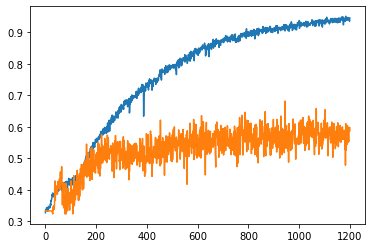

In [489]:
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])# history.history
plt.savefig("E:\\NN\\"+modelName+"_history.png")

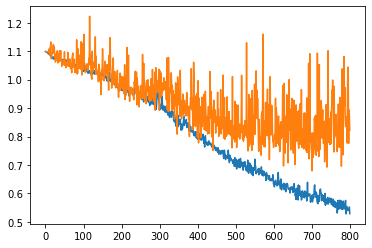

In [479]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])# history.history
plt.savefig("E:\\NN\\"+modelName+"_loss.png")

In [593]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# labels = (train_generator.class_indices)
pred = model.predict_generator(loadTest(testData),verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for ind,(dataP,label) in enumerate(loadTest(testData)):
    y = y+list(np.argmax(label,axis=1))
# print(pred[1:100],y[1:100])

      1/Unknown - 0s 156ms/step

C:\Users\dzemel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


153/153 [==============================] - 1s 5ms/step
[0 1]


0.7702407002188184


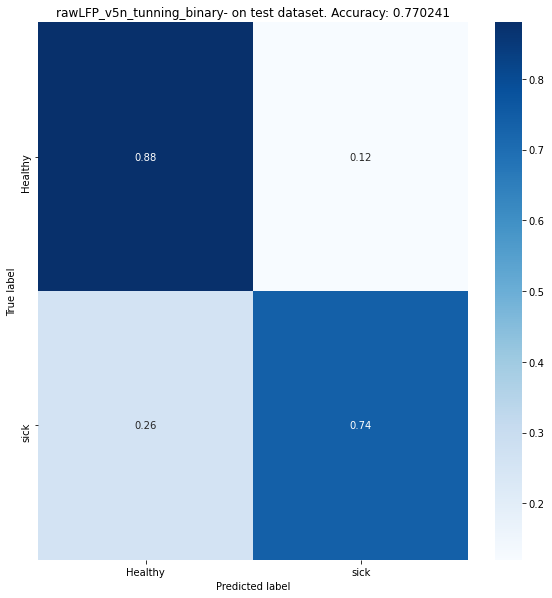

In [595]:
classes=['Healthy','sick']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on test dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Test.png")
print(np.sum(y==pred)/len(y))

In [596]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# labels = (train_generator.class_indices)
pred = model.predict_generator(loadTest(validate),verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for ind,(dataP,label) in enumerate(loadTest(validate)):
    y = y+list(np.argmax(label,axis=1))
# print(pred[1:100],y[1:100])

100/100 [==============================] - 1s 6ms/step
[0 1]


0.46763392857142855


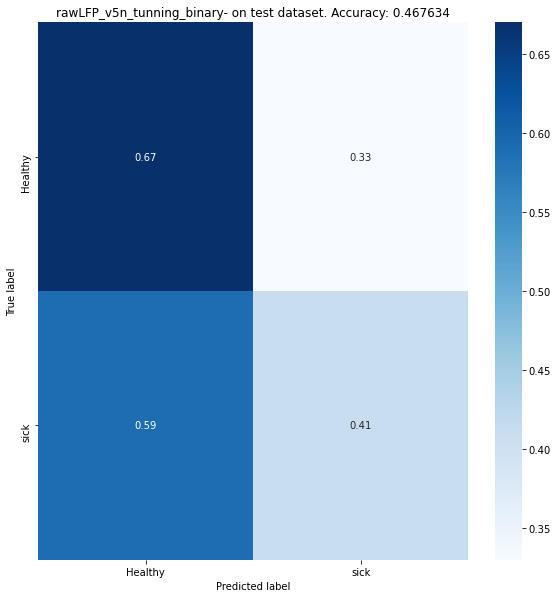

In [597]:
classes=['Healthy','sick']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on test dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_val.png")
print(np.sum(y==pred)/len(y))

In [598]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# labels = (train_generator.class_indices)
pred = model.predict_generator(loadTest(trainData),verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for ind,(dataP,label) in enumerate(loadTest(trainData)):
    y = y+list(np.argmax(label,axis=1))
# print(pred[1:100],y[1:100])

896/896 [==============================] - 4s 5ms/step
[0 1]


0.4740566037735849


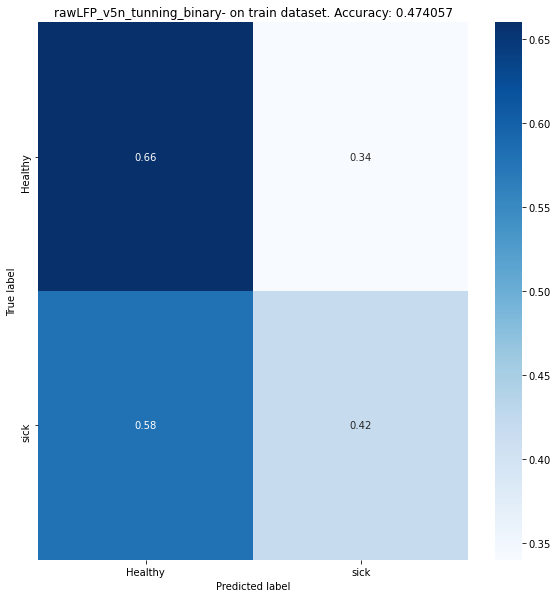

In [599]:
classes=['Healthy','sick']
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on train dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Train.png")
print(np.sum(y==pred)/len(y))

In [71]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")

# train_datagenT = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# train_generatorT = train_datagenT.flow_from_directory(
#     directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
#     target_size=(300, 300),
#     color_mode="grayscale",
#     batch_size=32,
#     class_mode="categorical",
#     shuffle=False,
#     seed=36
# )


labels = (train_generator.class_indices)
pred = model.predict_generator(train_generatorT,verbose=1)
pred = np.argmax(pred,axis=1)
print(np.unique(pred))

y = []
for f in train_generatorT.filenames:
    sess = f.split("_")[1]
    if sess[0] == 'B':
        day = 0
    else:
        day = int(re.findall(r'\d+',sess)[0])

    # get data
    period = periodCalc(day) 
    y.append(labels[period])

567/567 [==============================] - 89s 157ms/step
[0 1 2]


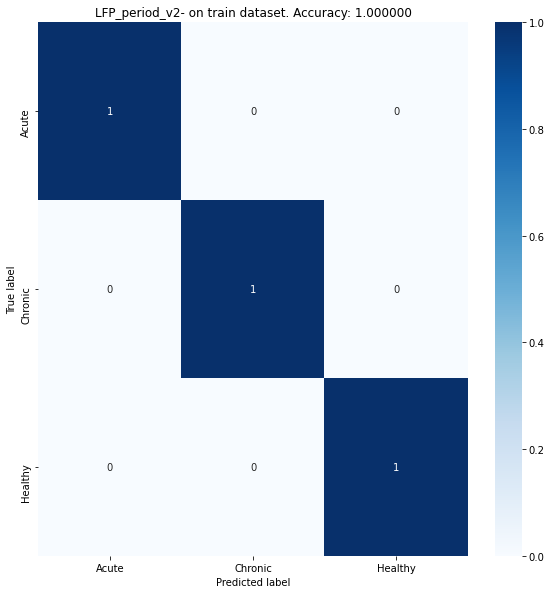

In [73]:
classes=labels.keys()
con_mat = tf.math.confusion_matrix(labels=y, predictions=pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title(modelName +"- on train dataset. Accuracy: {acc:f}".format(acc=np.sum(y==pred)/len(y)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("E:\\NN\\"+modelName+"_confusionOnTest_Train.png")


In [61]:
score = model.evaluate(train_generatorT)
print(score)

567/567 [==============================] - 89s 157ms/step - loss: 3.5345e-04 - accuracy: 1.0000
[0.00035344576463103294, 1.0]


In [56]:
pred = model.predict_generator(train_generator,verbose=1)
pred.shape

567/567 [==============================] - 89s 157ms/step


(18130, 3)

In [57]:
train_generatorT = train_datagen.flow_from_directory(
    directory="E:\\data\\Train\\",#'E:\\data\\imageTest\\training_set\\',#
    target_size=(300, 300),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=36
)


array([[9.9993336e-01, 6.6623645e-05, 2.0047966e-09],
       [1.0000000e+00, 1.3673330e-08, 4.0443326e-10],
       [3.7493074e-08, 1.0000000e+00, 1.9402356e-11],
       [3.0466440e-04, 9.9913293e-01, 5.6242698e-04]], dtype=float32)

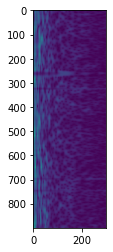

In [85]:
%matplotlib inline
for d,l in train_generator:
    plt.imshow(d[16,:,:,0])
    break